### Importing the Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from imblearn.under_sampling import NearMiss

In [2]:
# Configuration
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.max_columns', 500)

# Filter Warning
import warnings
warnings.filterwarnings('ignore')

In [3]:
def read_yaml_to_dict(file_path):
    """Reads a YAML file and returns its content as a dictionary."""
    import yaml
    try:
        with open(file_path, 'r') as file:
            data = yaml.safe_load(file)
        return data
    except FileNotFoundError:
        print(f"Error: File not found: {file_path}")
        return None
    except yaml.YAMLError as e:
        print(f"Error parsing YAML file: {e}")
        return None

In [4]:
features = read_yaml_to_dict("Modified Data/variable.yaml")
df = pd.read_csv("Modified Data/imputed_data.csv")

In [5]:
df.head()

,SEXVAR,_AGE80,_AGEG5YR,CVDINFR4,CVDCRHD4,CVDSTRK3,BPHIGH6,TOLDHI3,CHOLMED3,DIABETE4,CHCKDNY2,HAVARTH4,GENHLTH,PHYSHLTH,MENTHLTH,EXERANY2,STRENGTH,SMOKE100,USENOW3,ECIGNOW2,ALCDAY4,WEIGHT2,HEIGHT3,_BMI5
0,Female,80,Age 80 or older,No,No,No,Yes,No,No,Yes,No,No,Very good,30,30,No,0,No,Not at all,Never,0,172.0,5.250000,30.47
1,Female,80,Age 80 or older,No,No,No,Yes,Yes,Yes,No,No,Yes,Very good,30,30,Yes,0,No,Not at all,Never,0,132.0,4.750000,28.56
2,Female,80,Age 80 or older,No,No,No,Yes,Yes,Yes,No,No,Yes,Fair,6,2,Yes,5,Yes,Not at all,Never,0,130.0,5.333333,22.31
3,Female,78,Age 75 to 79,No,No,No,No,No,No,No,No,Yes,Very good,2,30,Yes,0,No,Not at all,Never,0,170.0,5.500000,27.44
4,Female,76,Age 75 to 79,No,No,No,Yes,No,No,Yes,No,Yes,Fair,30,30,Yes,0,No,Some days,Never,2,170.0,5.666667,25.85


In [6]:
rename = {
  # Binary
  "SEXVAR": "Gender",
  "BPHIGH6": "High Blood Pressure",
  "CHCKDNY2": "Kidney Disease",
  "CHOLMED3": "Taking medicine for high cholesterol",
  "CVDCRHD4": "Angina or Coronary Heart Disease",
  "CVDSTRK3": "Stroke",
  "DIABETE4": "Diabetes",
  "HAVARTH4": "Arthritis",
  "SMOKE100": "Smoked at Least 100 Cigarettes",
  "TOLDHI3": "Cholesterol Is High",
  "EXERANY2": "Exercise in Past 30 Days",
  "CVDINFR4": "Heart Attack",  # Target
  # Ordinal
  "ECIGNOW2": "E-cigarettes Frequency",
  "GENHLTH": "General Health",
  "USENOW3": "Smokeless Tobacco Products",
  "_AGEG5YR": "Age Range",
  # Numeric
  "_AGE80": "Age",
  "PHYSHLTH": "Number of Days Physical Health Not Good",
  "MENTHLTH": "Number of Days Mental Health Not Good",
  "STRENGTH": "Physical activities frequence",
  "ALCDAY4": "Days in past 30 had alcoholic beverage",
  "WEIGHT2": "Weight in Pounds",
  "HEIGHT3": "Reported Height in Feet",
  "_BMI5": "BMI"
}
df = df.rename(columns=rename)
df.head()

,Gender,Age,Age Range,Heart Attack,Angina or Coronary Heart Disease,Stroke,High Blood Pressure,Cholesterol Is High,Taking medicine for high cholesterol,Diabetes,Kidney Disease,Arthritis,General Health,Number of Days Physical Health Not Good,Number of Days Mental Health Not Good,Exercise in Past 30 Days,Physical activities frequence,Smoked at Least 100 Cigarettes,Smokeless Tobacco Products,E-cigarettes Frequency,Days in past 30 had alcoholic beverage,Weight in Pounds,Reported Height in Feet,BMI
0,Female,80,Age 80 or older,No,No,No,Yes,No,No,Yes,No,No,Very good,30,30,No,0,No,Not at all,Never,0,172.0,5.250000,30.47
1,Female,80,Age 80 or older,No,No,No,Yes,Yes,Yes,No,No,Yes,Very good,30,30,Yes,0,No,Not at all,Never,0,132.0,4.750000,28.56
2,Female,80,Age 80 or older,No,No,No,Yes,Yes,Yes,No,No,Yes,Fair,6,2,Yes,5,Yes,Not at all,Never,0,130.0,5.333333,22.31
3,Female,78,Age 75 to 79,No,No,No,No,No,No,No,No,Yes,Very good,2,30,Yes,0,No,Not at all,Never,0,170.0,5.500000,27.44
4,Female,76,Age 75 to 79,No,No,No,Yes,No,No,Yes,No,Yes,Fair,30,30,Yes,0,No,Some days,Never,2,170.0,5.666667,25.85


In [7]:
category_feature = ["Gender", "High Blood Pressure", "Kidney Disease", "Taking medicine for high cholesterol",
                    "Angina or Coronary Heart Disease", "Stroke", "Diabetes",  "Arthritis", "Smoked at Least 100 Cigarettes",
                    "Cholesterol Is High", "Exercise in Past 30 Days", "Heart Attack", "E-cigarettes Frequency", "General Health",
                    "Smokeless Tobacco Products", "Age Range"]

numeric_feature =  ["Age", "Number of Days Physical Health Not Good", "Number of Days Mental Health Not Good", "Physical activities frequence",
                    "Days in past 30 had alcoholic beverage", "Weight in Pounds", "Reported Height in Feet", "BMI"]

In [8]:
def draw_pie_plot(feature_list: list, df: pd.DataFrame):
    title_font = {"family" : "arial", "color" : "darkred", "weight" : "bold", "size" : 15}
    axis_font = {"family" : "arial", "color" : "darkblue", "weight" : "bold", "size" : 13}
    for col  in feature_list:
        fig, ax = plt.subplots(figsize = (8, 6))
        observation_values = list(df[col].value_counts().index)
        total_observation_values = list(df[col].value_counts())
        
        ax.pie(total_observation_values, labels= observation_values, autopct = '%1.1f%%', startangle = 110, labeldistance = 1.1)
        ax.axis("equal") # Equal aspect ratio ensures that pie is drawn as a circle.
        
        plt.title((col), fontdict = title_font) # Naming Pie Chart Titles
        plt.legend()
        plt.show()

In [9]:
def draw_density_plot(feature_list: list, target: str, df: pd.DataFrame):
    title_font = {"family" : "arial", "color" : "darkred", "weight" : "bold", "size" : 15}
    axis_font = {"family" : "arial", "color" : "darkblue", "weight" : "bold", "size" : 13}
    feature_list.append(target)
    for feature in feature_list:
        if feature != target:
            graph = sns.FacetGrid(df[feature_list], hue = target, height = 5, xlim = ((df[feature].min() - 10), (df[feature].max() + 10)))
            graph.map(sns.kdeplot, feature, shade = True)
            graph.add_legend()
            
            plt.title(feature, fontdict = title_font)
            plt.xlabel(feature, fontdict = axis_font)
            plt.ylabel("Density", fontdict = axis_font)
            
            plt.tight_layout()
            plt.show()

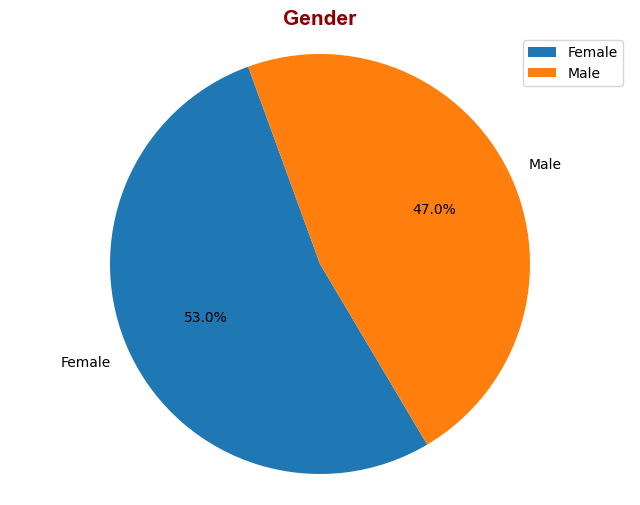

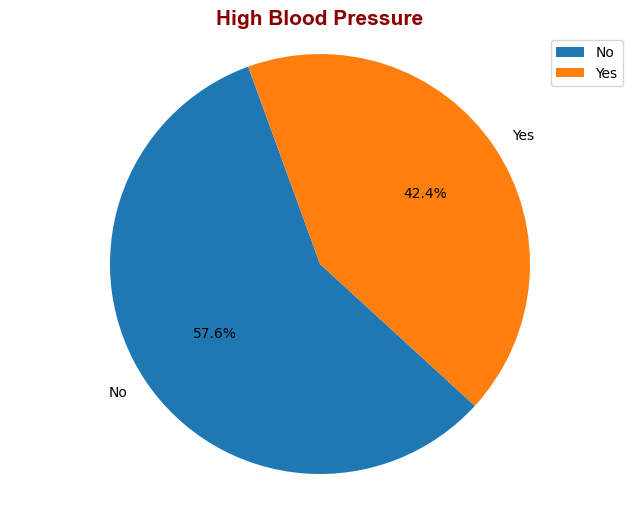

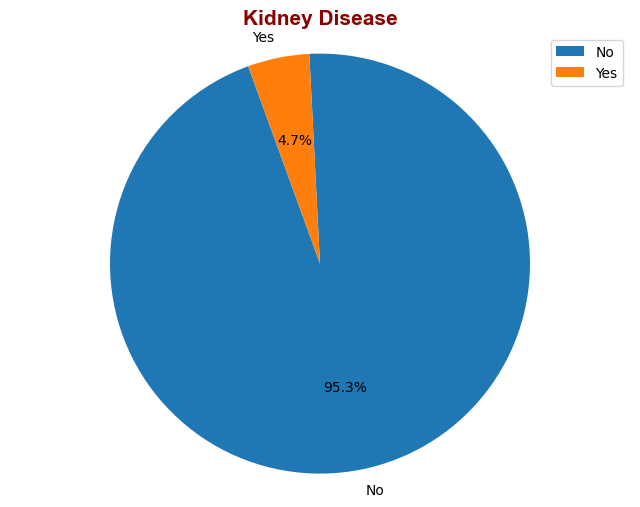

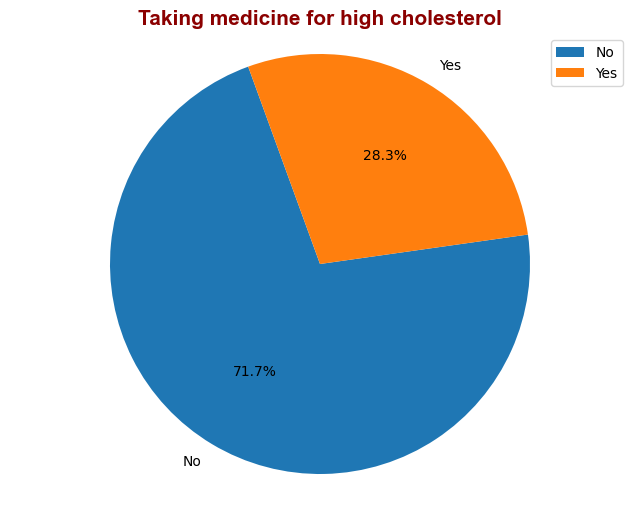

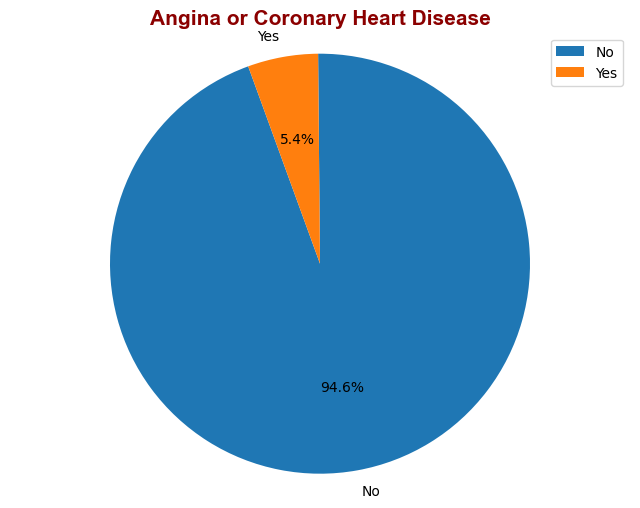

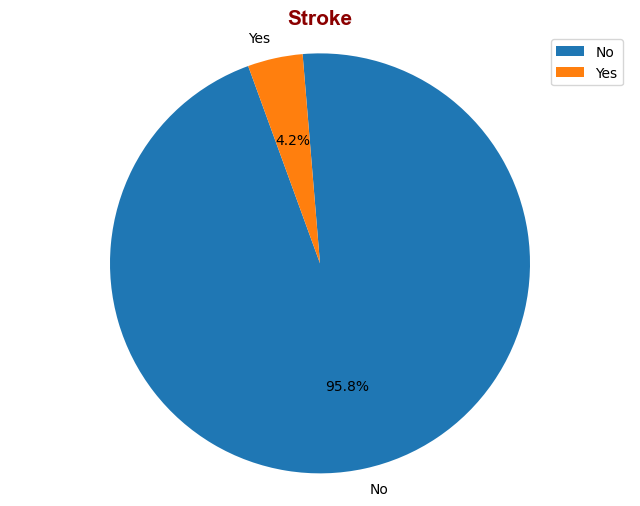

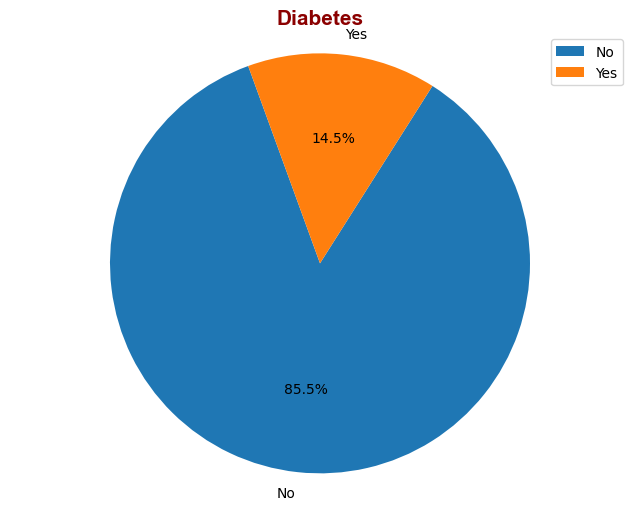

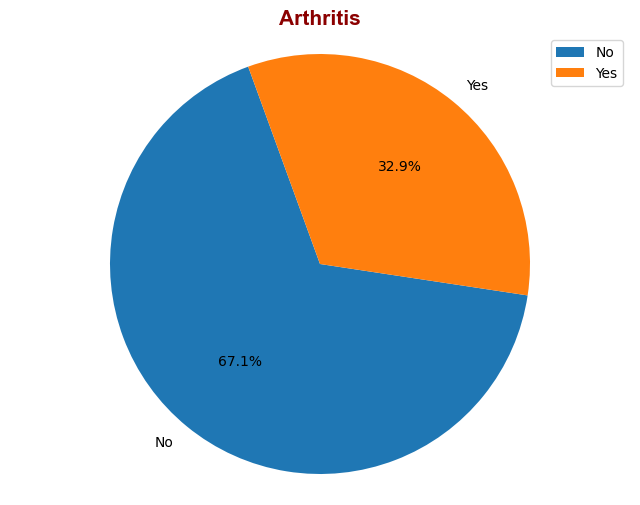

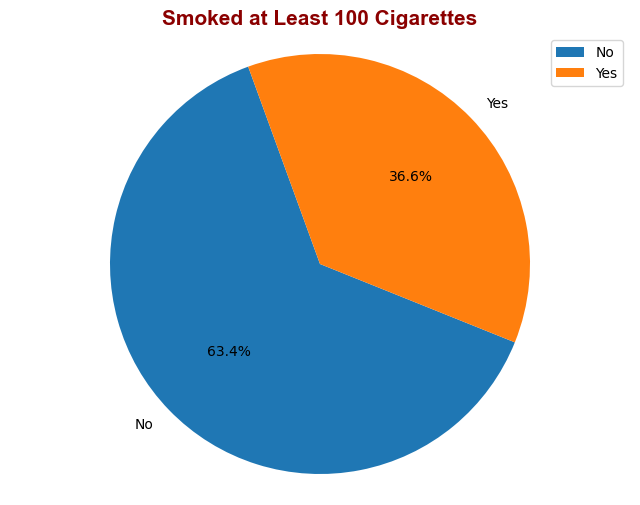

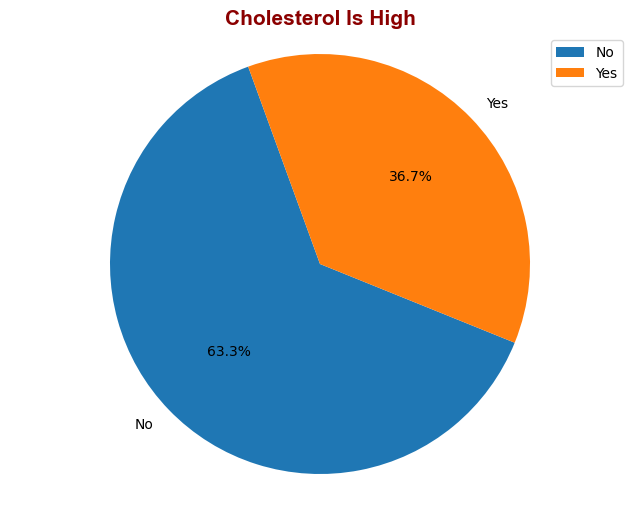

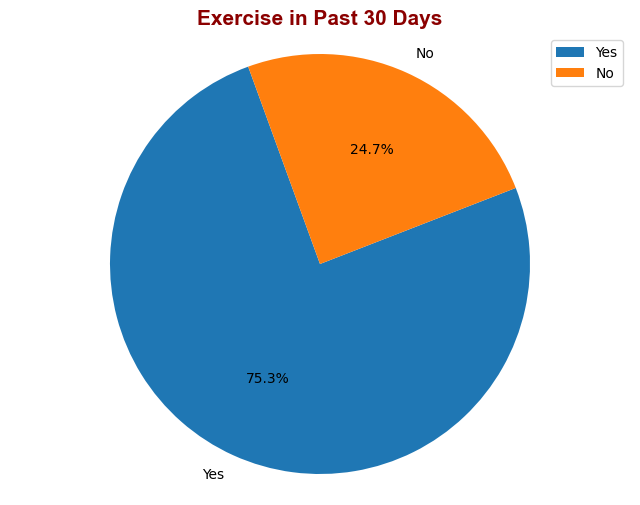

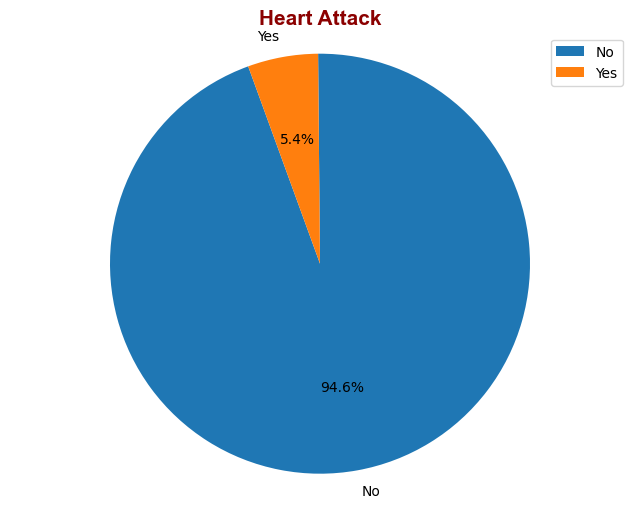

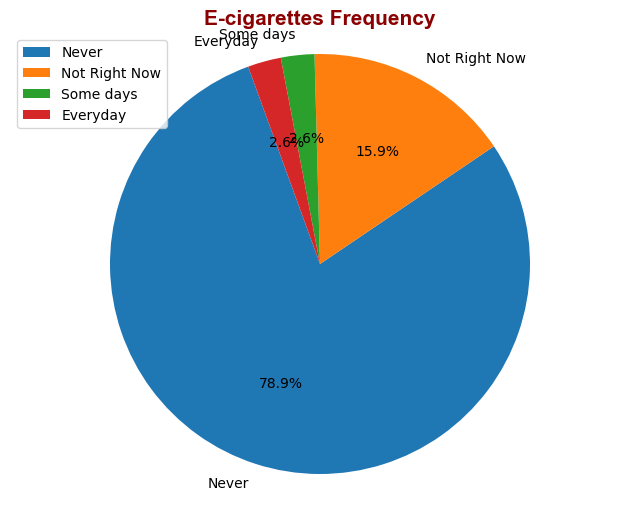

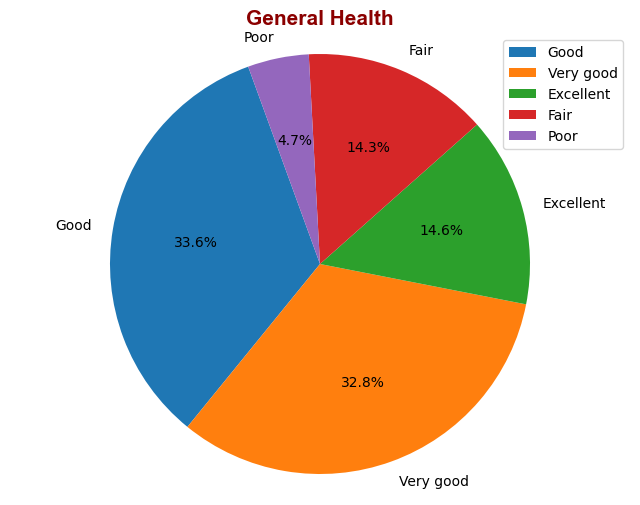

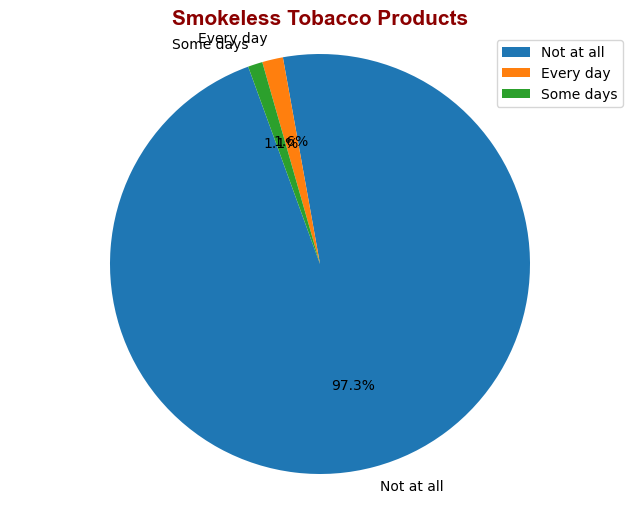

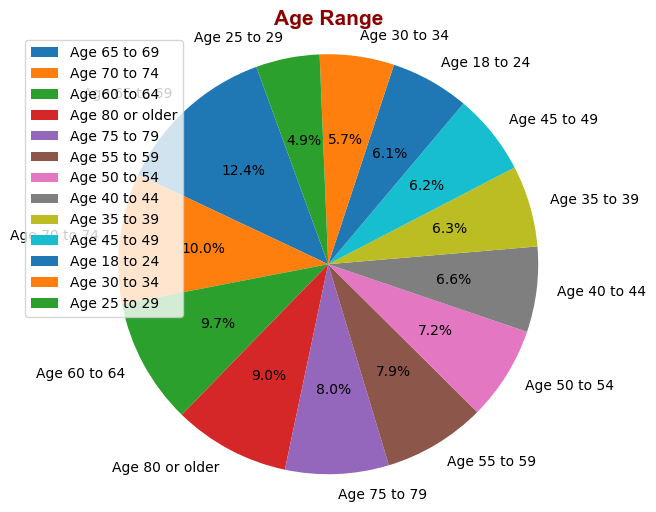

In [10]:
draw_pie_plot(category_feature, df)

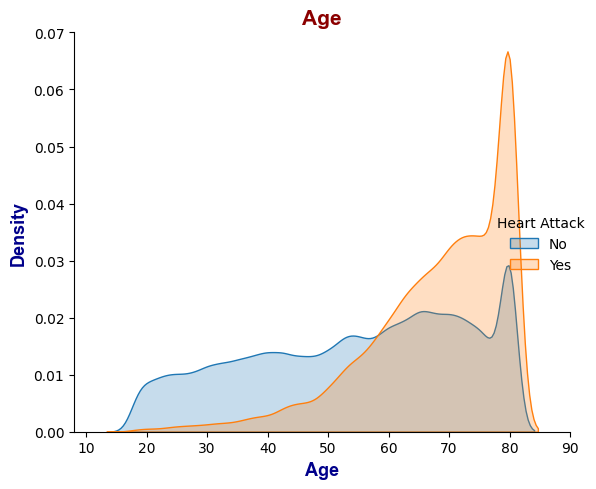

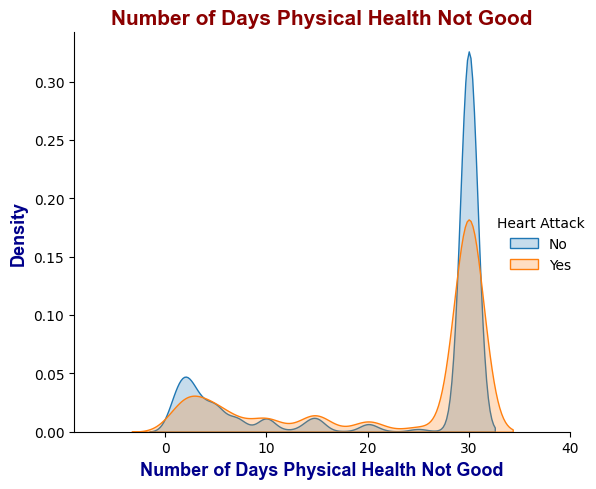

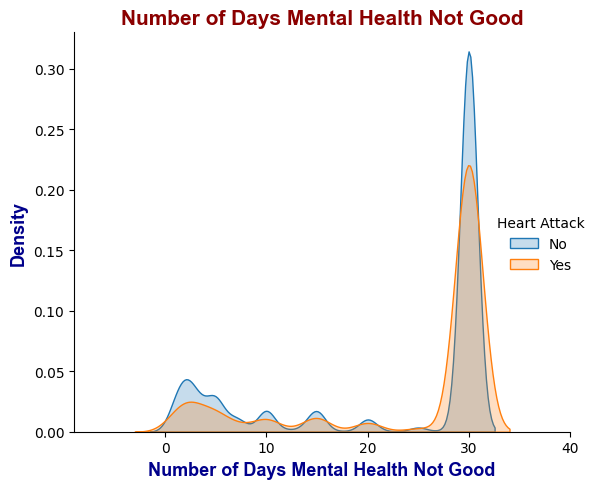

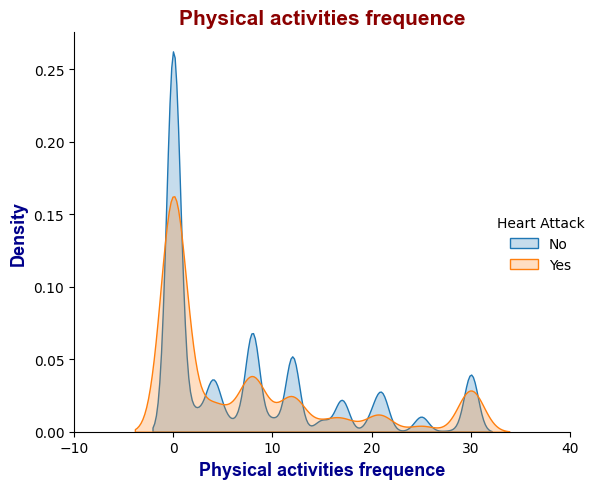

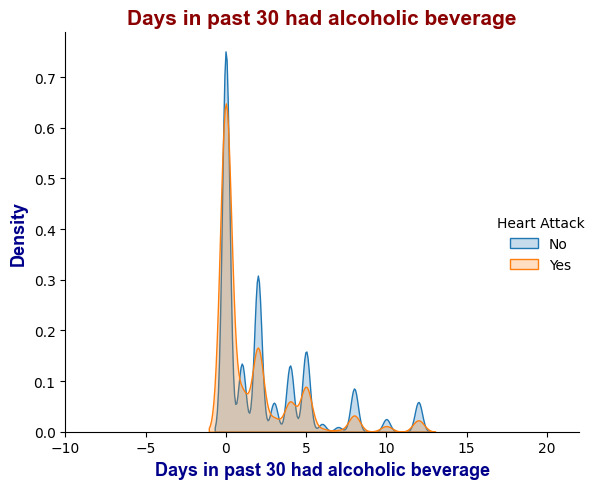

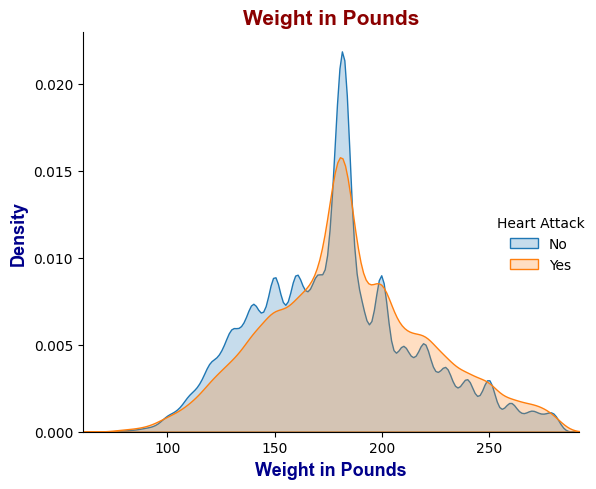

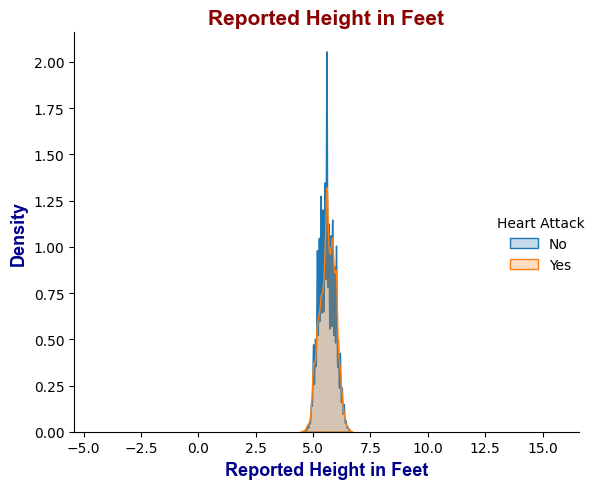

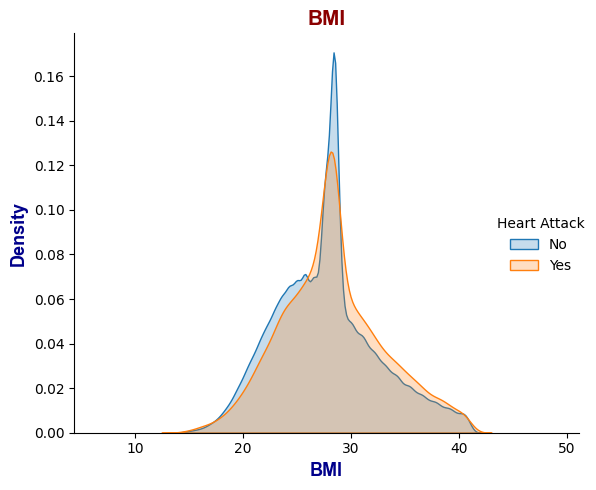

In [11]:
draw_density_plot(numeric_feature.copy(), "Heart Attack", df)

Age Range
Age 65 to 69       53878
Age 70 to 74       43533
Age 60 to 64       41974
Age 80 or older    38869
Age 75 to 79       34543
Age 55 to 59       34219
Age 50 to 54       31291
Age 40 to 44       28463
Age 35 to 39       27153
Age 45 to 49       27070
Age 18 to 24       26280
Age 30 to 34       24803
Age 25 to 29       21247
Name: count, dtype: int64

[Text(0, 0, 'Age 18 to 24'),
 Text(1, 0, 'Age 25 to 29'),
 Text(2, 0, 'Age 30 to 34'),
 Text(3, 0, 'Age 35 to 39'),
 Text(4, 0, 'Age 40 to 44'),
 Text(5, 0, 'Age 45 to 49'),
 Text(6, 0, 'Age 50 to 54'),
 Text(7, 0, 'Age 55 to 59'),
 Text(8, 0, 'Age 60 to 64'),
 Text(9, 0, 'Age 65 to 69'),
 Text(10, 0, 'Age 70 to 74'),
 Text(11, 0, 'Age 75 to 79'),
 Text(12, 0, 'Age 80 or older')]

<bound method Axes.set_title of <Axes: xlabel='Age Range', ylabel='count'>>

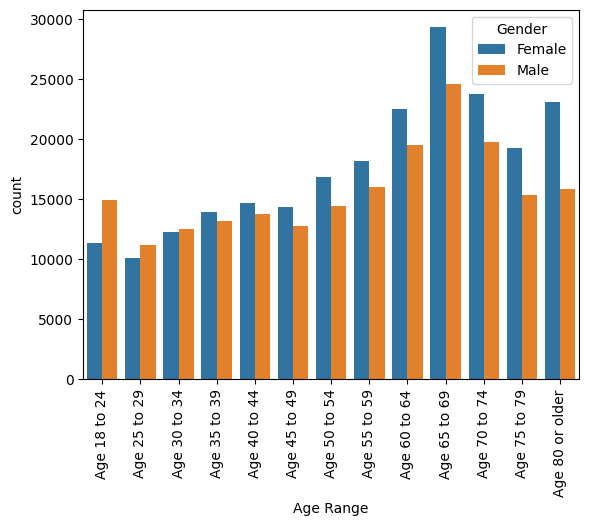

In [12]:
age_range_order = ["Age 18 to 24", "Age 25 to 29", "Age 30 to 34", "Age 35 to 39", "Age 40 to 44", "Age 45 to 49", "Age 50 to 54", "Age 55 to 59", "Age 60 to 64", "Age 65 to 69", "Age 70 to 74", "Age 75 to 79", "Age 80 or older"]
df["Age Range"].value_counts()
g = sns.countplot(x='Age Range', hue="Gender", order=age_range_order ,data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title

General Health
Good         145471
Very good    142115
Excellent     63410
Fair          61955
Poor          20372
Name: count, dtype: int64

[Text(0, 0, 'Poor'),
 Text(1, 0, 'Fair'),
 Text(2, 0, 'Good'),
 Text(3, 0, 'Very good'),
 Text(4, 0, 'Excellent')]

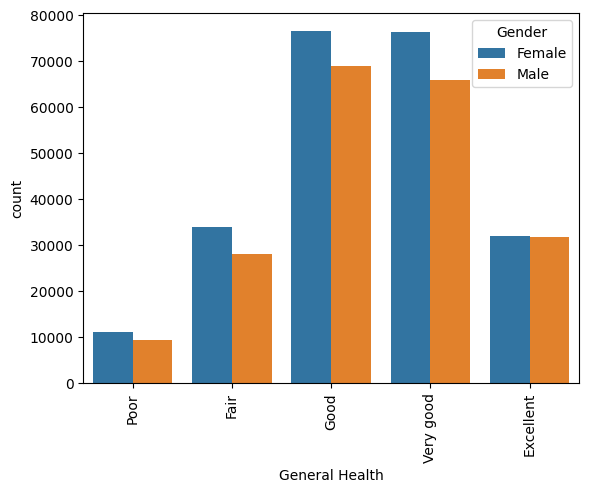

In [13]:
general_health_order = ["Poor", "Fair", "Good", "Very good", "Excellent"]
df["General Health"].value_counts()
g = sns.countplot(x='General Health', hue="Gender", order=general_health_order ,data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

E-cigarettes Frequency
Never            341947
Not Right Now     69110
Some days         11164
Everyday          11102
Name: count, dtype: int64

[Text(0, 0, 'Never'),
 Text(1, 0, 'Not Right Now'),
 Text(2, 0, 'Some days'),
 Text(3, 0, 'Everyday')]

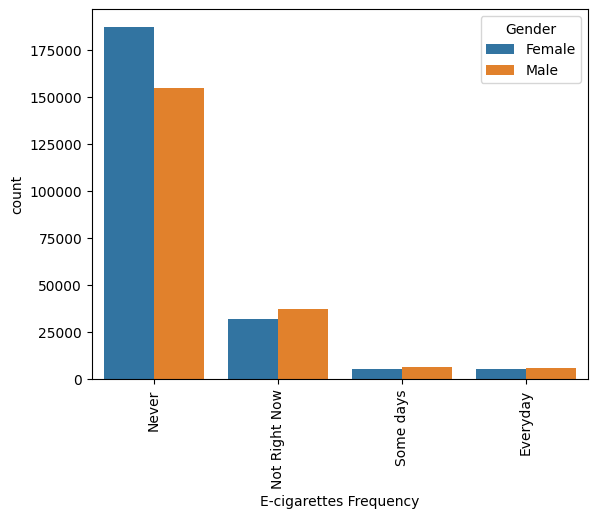

In [14]:
E_cigarettes_frequency_order = ["Never", "Not Right Now", "Some days", "Everyday"]
df["E-cigarettes Frequency"].value_counts()
g = sns.countplot(x='E-cigarettes Frequency', hue="Gender", order=E_cigarettes_frequency_order ,data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

Smokeless Tobacco Products
Not at all    421510
Every day       6951
Some days       4862
Name: count, dtype: int64

[Text(0, 0, 'Not at all'), Text(1, 0, 'Some days'), Text(2, 0, 'Every day')]

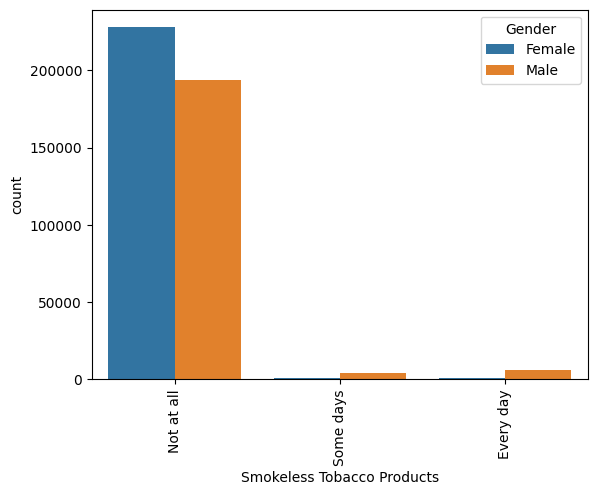

In [15]:
smokeless_tobacco_order = ["Not at all", "Some days", "Every day"]
df["Smokeless Tobacco Products"].value_counts()
g = sns.countplot(x='Smokeless Tobacco Products', hue="Gender", order=smokeless_tobacco_order ,data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)


### Encode the data (Category feature)

In [16]:
ordinal_categories = [age_range_order, general_health_order, E_cigarettes_frequency_order, smokeless_tobacco_order]
ordinal_features = ["Age Range", "General Health", "E-cigarettes Frequency", "Smokeless Tobacco Products"]

ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)
df[ordinal_features] = ordinal_encoder.fit_transform(df[ordinal_features])
df[ordinal_features] = df[ordinal_features].astype(int)

df.head()

,Gender,Age,Age Range,Heart Attack,Angina or Coronary Heart Disease,Stroke,High Blood Pressure,Cholesterol Is High,Taking medicine for high cholesterol,Diabetes,Kidney Disease,Arthritis,General Health,Number of Days Physical Health Not Good,Number of Days Mental Health Not Good,Exercise in Past 30 Days,Physical activities frequence,Smoked at Least 100 Cigarettes,Smokeless Tobacco Products,E-cigarettes Frequency,Days in past 30 had alcoholic beverage,Weight in Pounds,Reported Height in Feet,BMI
0,Female,80,12,No,No,No,Yes,No,No,Yes,No,No,3,30,30,No,0,No,0,0,0,172.0,5.250000,30.47
1,Female,80,12,No,No,No,Yes,Yes,Yes,No,No,Yes,3,30,30,Yes,0,No,0,0,0,132.0,4.750000,28.56
2,Female,80,12,No,No,No,Yes,Yes,Yes,No,No,Yes,1,6,2,Yes,5,Yes,0,0,0,130.0,5.333333,22.31
3,Female,78,11,No,No,No,No,No,No,No,No,Yes,3,2,30,Yes,0,No,0,0,0,170.0,5.500000,27.44
4,Female,76,11,No,No,No,Yes,No,No,Yes,No,Yes,1,30,30,Yes,0,No,1,0,2,170.0,5.666667,25.85


In [17]:
binary_features = ["Gender", "High Blood Pressure", "Kidney Disease", "Taking medicine for high cholesterol", "Angina or Coronary Heart Disease", 
                   "Heart Attack", "Stroke", "Diabetes", "Arthritis", "Smoked at Least 100 Cigarettes", "Cholesterol Is High", "Exercise in Past 30 Days"]

label_encoder = LabelEncoder()
for features in binary_features:
    df[features] = label_encoder.fit_transform(df[features])

df.head()

,Gender,Age,Age Range,Heart Attack,Angina or Coronary Heart Disease,Stroke,High Blood Pressure,Cholesterol Is High,Taking medicine for high cholesterol,Diabetes,Kidney Disease,Arthritis,General Health,Number of Days Physical Health Not Good,Number of Days Mental Health Not Good,Exercise in Past 30 Days,Physical activities frequence,Smoked at Least 100 Cigarettes,Smokeless Tobacco Products,E-cigarettes Frequency,Days in past 30 had alcoholic beverage,Weight in Pounds,Reported Height in Feet,BMI
0,0,80,12,0,0,0,1,0,0,1,0,0,3,30,30,0,0,0,0,0,0,172.0,5.250000,30.47
1,0,80,12,0,0,0,1,1,1,0,0,1,3,30,30,1,0,0,0,0,0,132.0,4.750000,28.56
2,0,80,12,0,0,0,1,1,1,0,0,1,1,6,2,1,5,1,0,0,0,130.0,5.333333,22.31
3,0,78,11,0,0,0,0,0,0,0,0,1,3,2,30,1,0,0,0,0,0,170.0,5.500000,27.44
4,0,76,11,0,0,0,1,0,0,1,0,1,1,30,30,1,0,0,1,0,2,170.0,5.666667,25.85


In [18]:
def summarize_correlations(corr_matrix):
    summary = {
        "Very Strong": [],
        "Strong": [],
        "Moderate": [],
        "Weak": [],
        "Very Weak/No Correlation": []
    }

    for col in corr_matrix.columns:
        for idx in corr_matrix.index:
            if col != idx:  # Avoid self-correlation
                value = corr_matrix.loc[idx, col]
                if abs(value) >= 0.9:
                    summary["Very Strong"].append((idx, col, value))
                elif abs(value) >= 0.7:
                    summary["Strong"].append((idx, col, value))
                elif abs(value) >= 0.5:
                    summary["Moderate"].append((idx, col, value))
                elif abs(value) >= 0.3:
                    summary["Weak"].append((idx, col, value))
                else:
                    summary["Very Weak/No Correlation"].append((idx, col, value))

    return summary

In [19]:
df[numeric_feature].corr()

,Age,Number of Days Physical Health Not Good,Number of Days Mental Health Not Good,Physical activities frequence,Days in past 30 had alcoholic beverage,Weight in Pounds,Reported Height in Feet,BMI
Age,1.000000,0.082151,0.222881,-0.023529,-0.107498,-0.038449,-0.113487,0.016907
Number of Days Physical Health Not Good,0.082151,1.000000,0.200801,0.029651,-0.016337,-0.020642,0.019910,-0.031092
Number of Days Mental Health Not Good,0.222881,0.200801,1.000000,0.019558,-0.056284,0.017442,0.029977,0.009184
Physical activities frequence,-0.023529,0.029651,0.019558,1.000000,0.035075,-0.055993,0.063655,-0.101488
Days in past 30 had alcoholic beverage,-0.107498,-0.016337,-0.056284,0.035075,1.000000,0.015870,0.103784,-0.035462
Weight in Pounds,-0.038449,-0.020642,0.017442,-0.055993,0.015870,1.000000,0.461292,0.753435
Reported Height in Feet,-0.113487,0.019910,0.029977,0.063655,0.103784,0.461292,1.000000,0.021366
BMI,0.016907,-0.031092,0.009184,-0.101488,-0.035462,0.753435,0.021366,1.000000


<Axes: >


Very Strong Correlations:
Age Range - Age: 0.99
Age - Age Range: 0.99

Strong Correlations:
BMI - Weight in Pounds: 0.75
Weight in Pounds - BMI: 0.75

Moderate Correlations:
Reported Height in Feet - Gender: 0.68
Taking medicine for high cholesterol - Cholesterol Is High: 0.60
Cholesterol Is High - Taking medicine for high cholesterol: 0.60
Gender - Reported Height in Feet: 0.68

Weak Correlations:
Weight in Pounds - Gender: 0.35
High Blood Pressure - Age: 0.37
Cholesterol Is High - Age: 0.32
Taking medicine for high cholesterol - Age: 0.42
Arthritis - Age: 0.39
High Blood Pressure - Age Range: 0.36
Cholesterol Is High - Age Range: 0.31
Taking medicine for high cholesterol - Age Range: 0.42
Arthritis - Age Range: 0.38
Angina or Coronary Heart Disease - Heart Attack: 0.42
Heart Attack - Angina or Coronary Heart Disease: 0.42
Age - High Blood Pressure: 0.37
Age Range - High Blood Pressure: 0.36
Taking medicine for high cholesterol - High Blood Pressure: 0.35
Age - Cholesterol Is High: 0

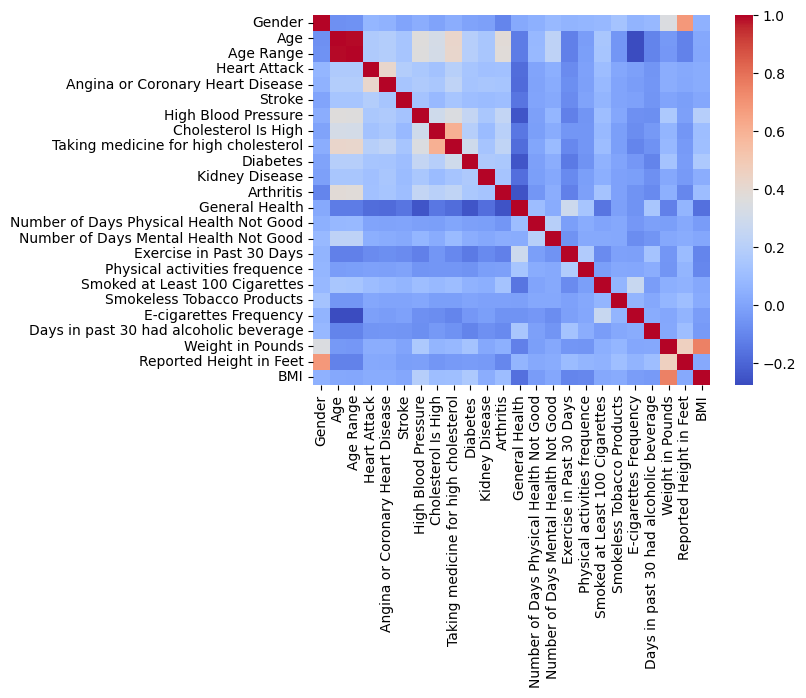

In [20]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm')
correlation_summary = summarize_correlations(correlation_matrix)

for category, correlations in correlation_summary.items():
    print(f"\n{category} Correlations:")
    for feature1, feature2, value in correlations:
        print(f"{feature1} - {feature2}: {value:.2f}")


### Undersampling

<Axes: >

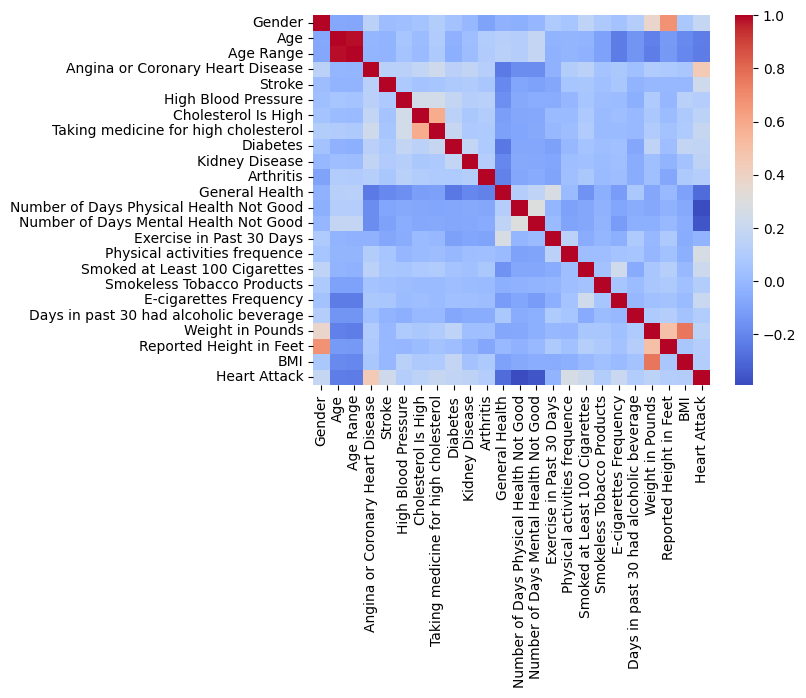

In [21]:
target = "Heart Attack"
X = df.drop(columns=[target])
y = df[target]

under_sampler = NearMiss(version=1)
X_resampled, y_resampled = under_sampler.fit_resample(X, y)

df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled[target] = y_resampled

correlation_matrix = df_resampled.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm')

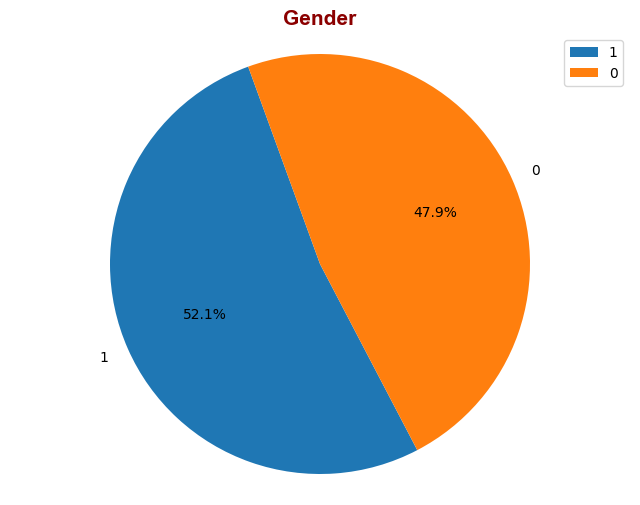

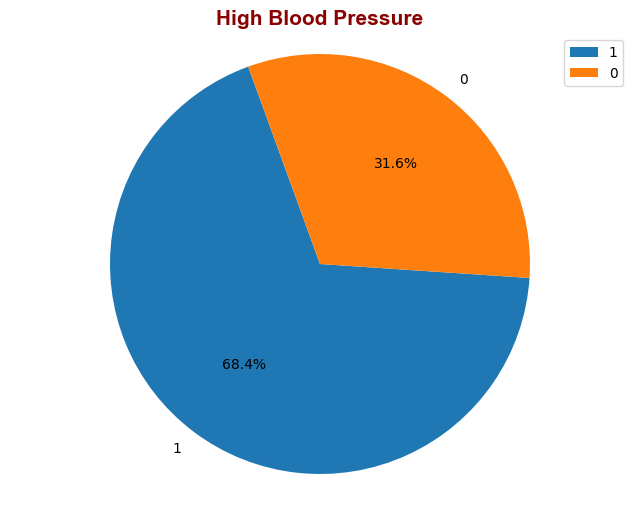

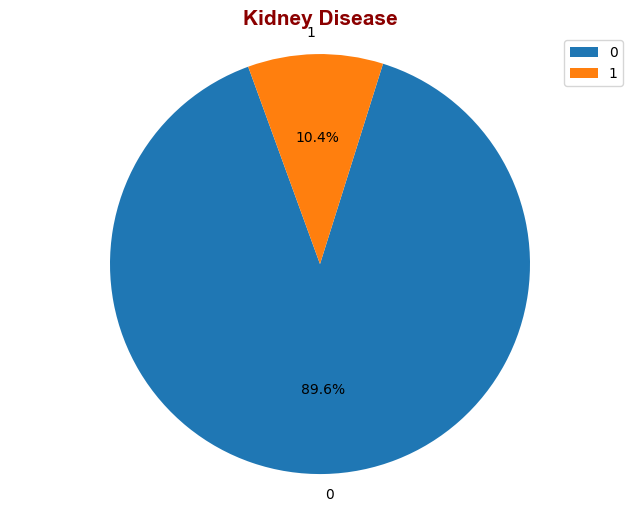

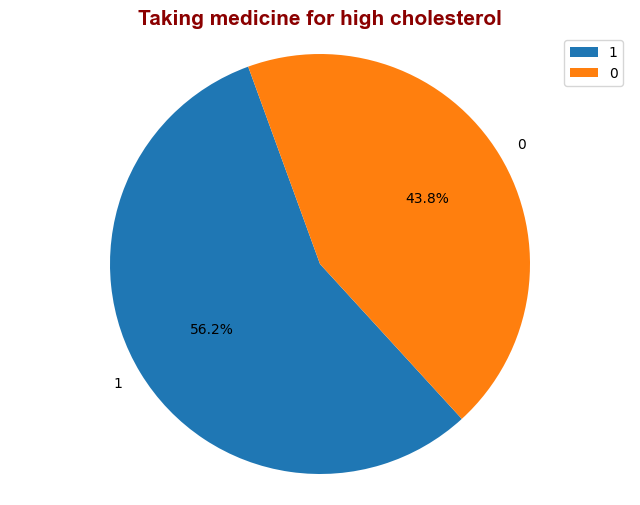

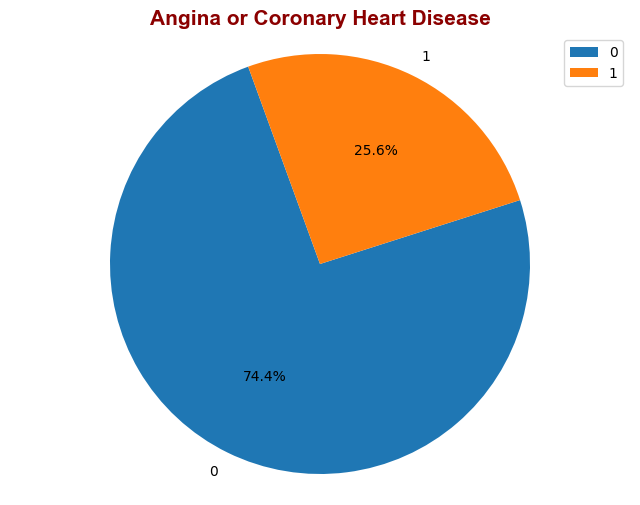

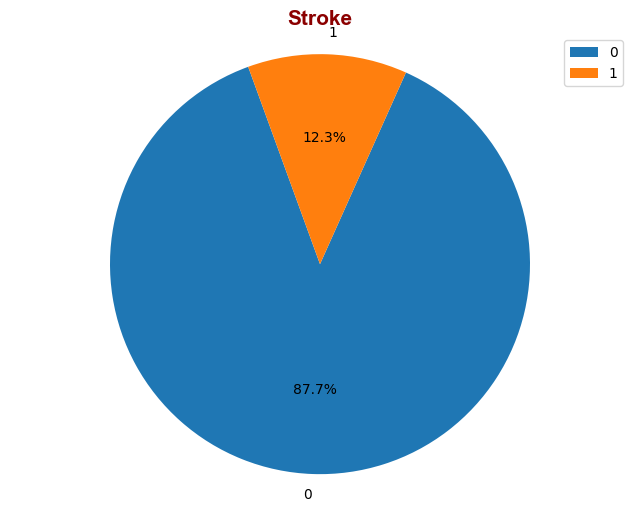

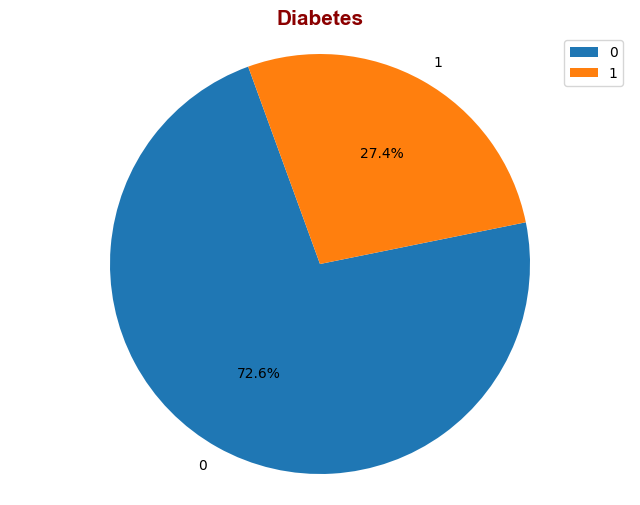

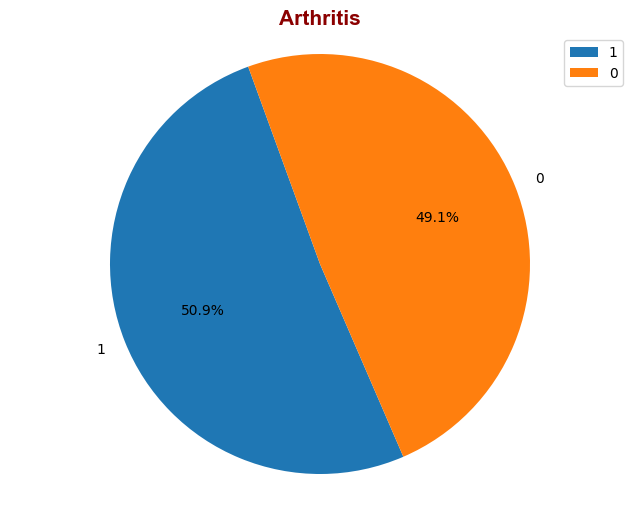

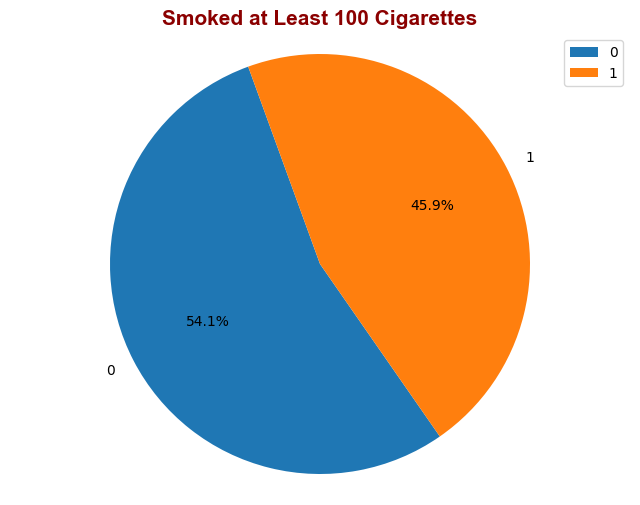

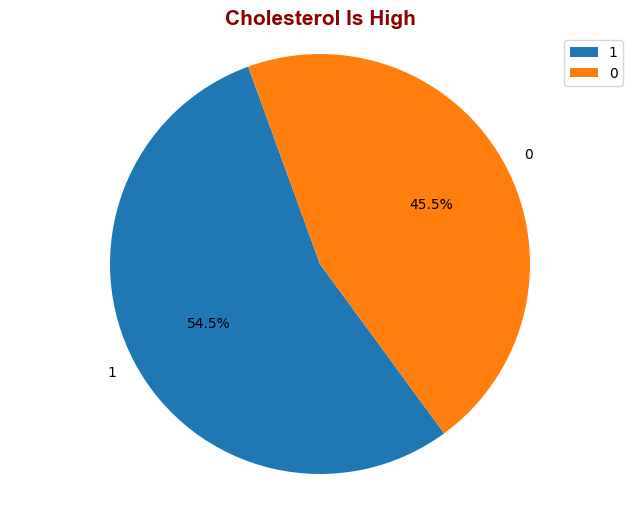

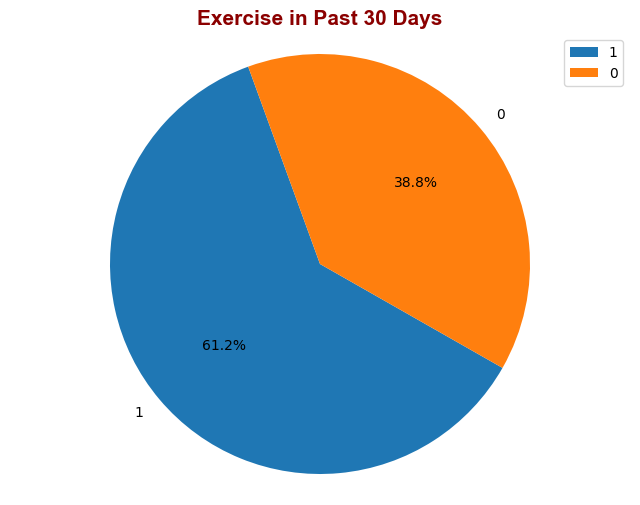

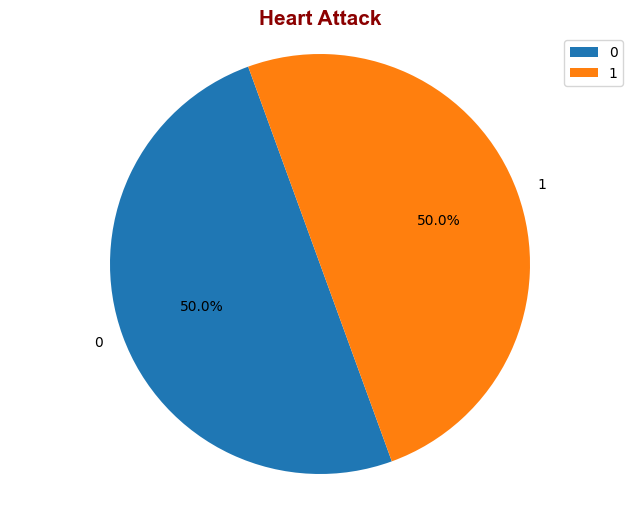

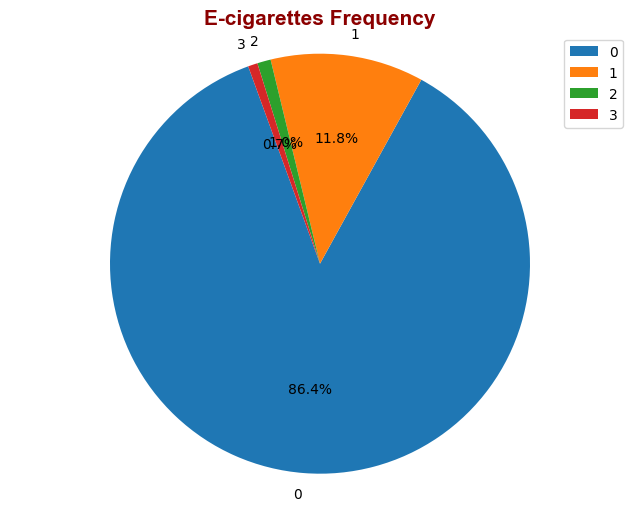

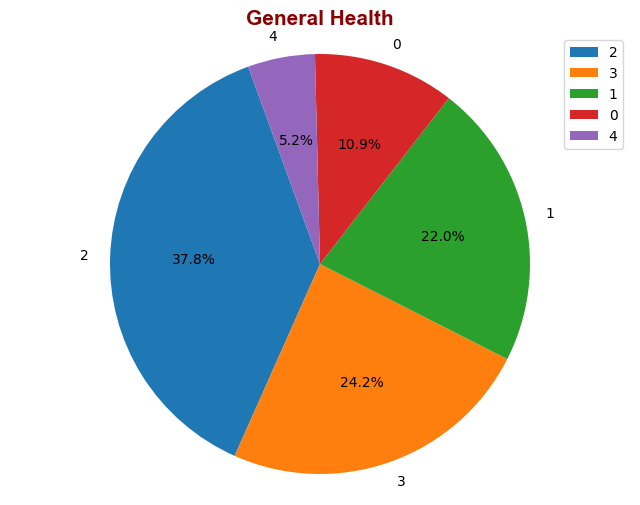

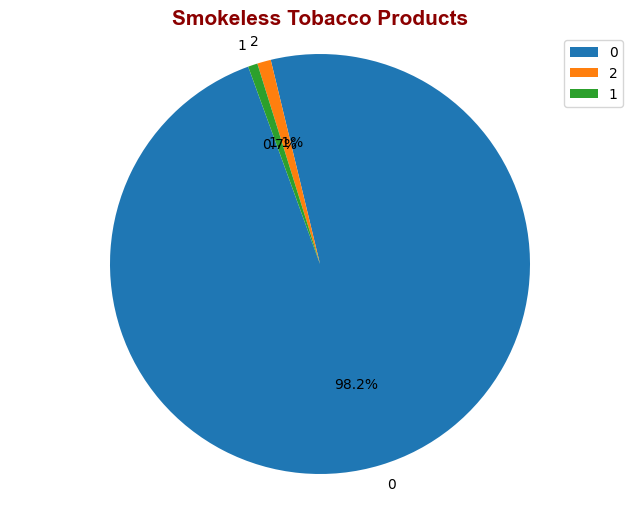

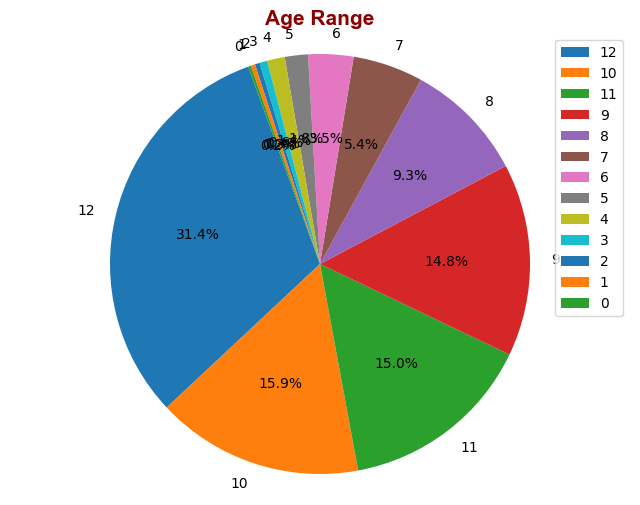

In [22]:
draw_pie_plot(category_feature, df_resampled)

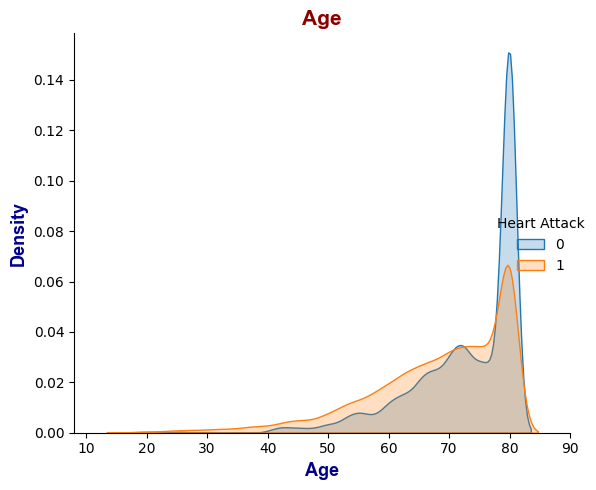

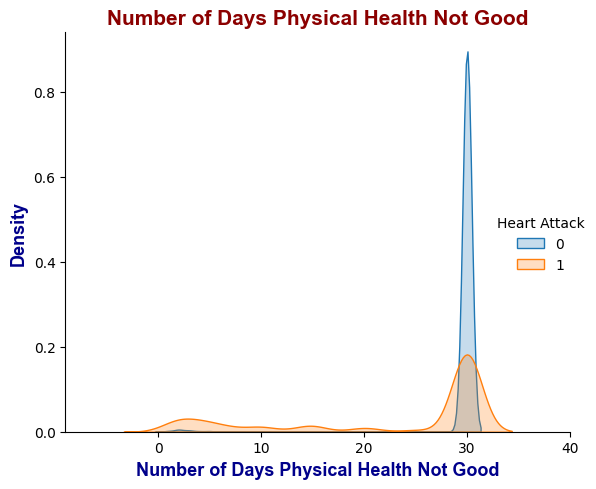

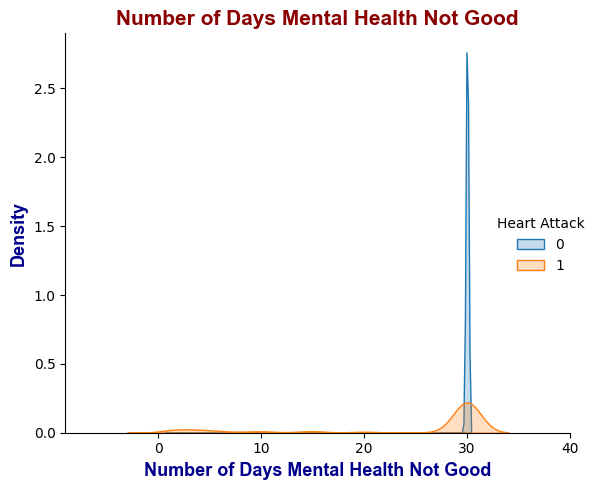

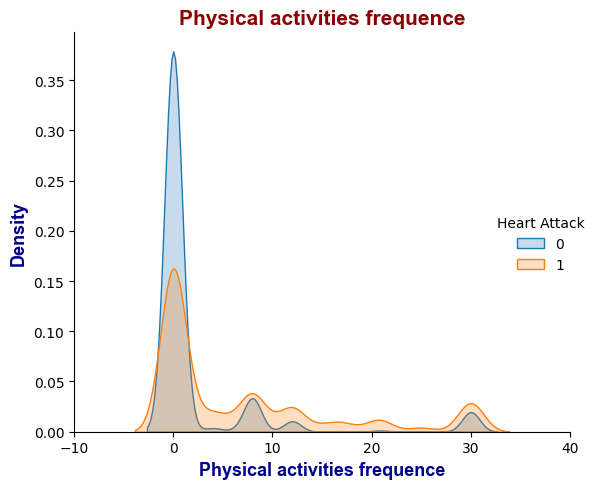

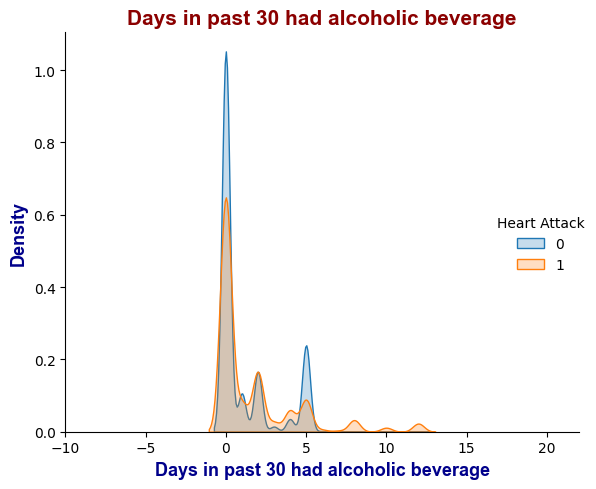

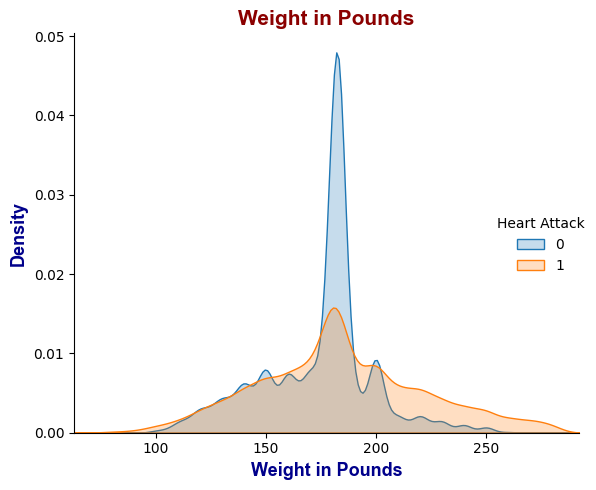

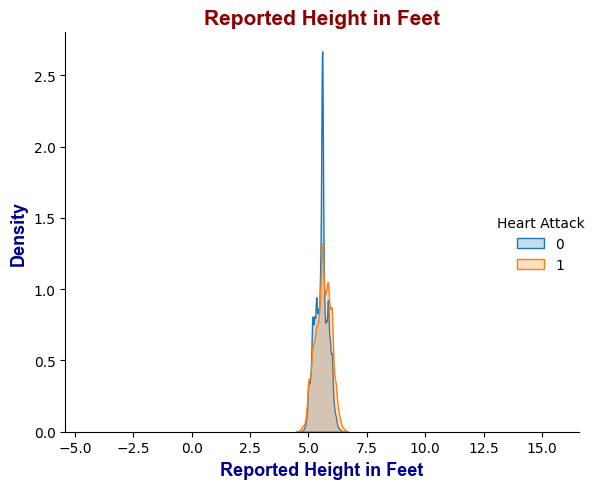

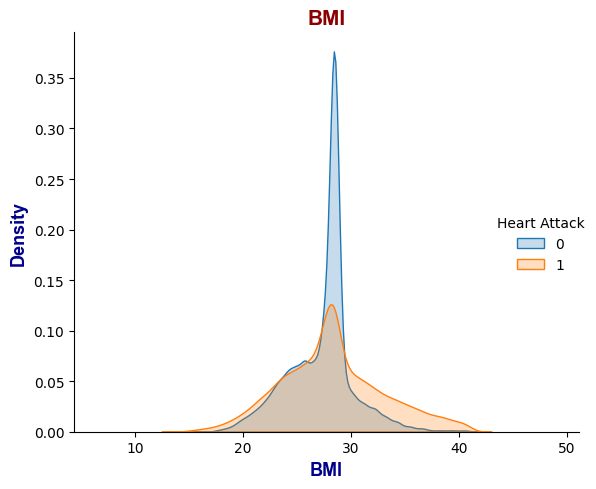

In [23]:
draw_density_plot(numeric_feature.copy(), "Heart Attack", df_resampled)

In [24]:
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46902 entries, 0 to 46901
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Gender                                   46902 non-null  int64  
 1   Age                                      46902 non-null  int64  
 2   Age Range                                46902 non-null  int64  
 3   Angina or Coronary Heart Disease         46902 non-null  int64  
 4   Stroke                                   46902 non-null  int64  
 5   High Blood Pressure                      46902 non-null  int64  
 6   Cholesterol Is High                      46902 non-null  int64  
 7   Taking medicine for high cholesterol     46902 non-null  int64  
 8   Diabetes                                 46902 non-null  int64  
 9   Kidney Disease                           46902 non-null  int64  
 10  Arthritis                                46902

#### Visualization

### Creating New Features

In [25]:
# df["Age_BMI"] = df["Age"] * df["BMI"]  # Interaction between age and BMI
# df["Exercise_BMI"] = df["Exercise in Past 30 Days"] * df["BMI"]  # Effect of exercise on BMI
# df["Alcohol_Smoking"] = df["Days in past 30 had alcoholic beverage"] * df["Smoked at Least 100 Cigarettes"]  # Relationship between drinking and smoking

In [26]:
# df["Health_Risk_Score"] = df[["High Blood Pressure", "Diabetes", "Taking medicine for high cholesterol", "Stroke"]].sum(axis=1)

In [27]:
# df.head()

In [28]:
# correlation_matrix = df.corr()
# sns.heatmap(correlation_matrix, cmap='coolwarm')
# correlation_summary = summarize_correlations(correlation_matrix)

# for category, correlations in correlation_summary.items():
#     print(f"\n{category} Correlations:")
#     for feature1, feature2, value in correlations:
#         print(f"{feature1} - {feature2}: {value:.2f}")

In [29]:
# # From https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html
# # Code source: Jaques Grobler
# # License: BSD 3 clause

# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# from sklearn import datasets, linear_model
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler

# target = "Heart Attack"
# X = df.drop(columns=[target])
# y = df[target]

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
# # Scale the data using StandardScaler
# scaler = StandardScaler()
# diabetes_X_train = scaler.fit_transform(X_train)
# diabetes_X_test = scaler.transform(X_test)

# ####################################################################
# # Quick Helper Method - Find Best Parameters
# # Define parameter grid
# param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
 
# # Perform grid search with cross-validation
# lasso_cv = GridSearchCV(linear_model.Lasso(), param_grid, cv=5)
# lasso_cv.fit(X_train, y_train)
 
# # Print best parameter values and score
# print("Best Parameters:", lasso_cv.best_params_)
# print("Best Score:", lasso_cv.best_score_)
# ####################################################################

# # Fit Lasso regression model
# lasso = linear_model.Lasso(alpha=1)
# lasso.fit(X_train, y_train)
 
# # Evaluate model performance on test set
# y_pred = lasso.predict(X_test)

# # The coefficients
# print("Coefficients: \n", lasso.coef_)
# # The mean squared error
# print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# # The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.2f" % lasso.score(X_test, y_test))

In [30]:
# from sklearn.cluster import KMeans

# # Run K-Means for different K values
# inertia = []
# K_values = range(2, 11)  # Testing from 2 to 10 clusters

# for k in K_values:
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     kmeans.fit(df)  # df_processed = Preprocessed dataset
#     inertia.append(kmeans.inertia_)

# # Plot the Elbow Curve
# plt.plot(K_values, inertia, marker='o')
# plt.xlabel('Number of Clusters (K)')
# plt.ylabel('Inertia')
# plt.title('Elbow Method for Optimal K')
# plt.show()

In [31]:
# from kneed import KneeLocator

# knee_locator = KneeLocator(range(2, 11), inertia, curve="convex", direction="decreasing")
# optimal_k = knee_locator.knee

# print(f"Optimal number of clusters: {optimal_k}")

In [32]:
# kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
# df["Cluster"] = kmeans.fit_predict(df)

# # Check cluster distribution
# df["Cluster"].value_counts()

In [33]:
# # Visualize clusters based on important features
# sns.boxplot(x="Cluster", y="BMI", data=df)
# plt.title("BMI Distribution Across Clusters")
# plt.show()

# sns.boxplot(x="Cluster", y="Age", data=df)
# plt.title("Age Distribution Across Clusters")
# plt.show()

In [34]:
# # Reduce to 2D using PCA for visualization
# pca = PCA(n_components=2)
# reduced_features = pca.fit_transform(df)
# df["PCA1"] = reduced_features[:, 0]
# df["PCA2"] = reduced_features[:, 1]

# # Plot clusters with colors
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=df["PCA1"], y=df["PCA2"], hue=df["Cluster"], palette="tab10", alpha=0.7)
# plt.xlabel("Principal Component 1")
# plt.ylabel("Principal Component 2")
# plt.title("K-Means Clustering Visualization (PCA Reduced)")
# plt.legend(title="Cluster")
# plt.show()

In [35]:
# target = "Heart Attack"
# X = df.drop(columns=[target])
# y = df[target]

# # Standardize the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)


In [36]:
# from sklearn.decomposition import TruncatedSVD


# # Apply SVD for dimensionality reduction
# num_components = 10  # Adjust based on explained variance
# svd = TruncatedSVD(n_components=num_components)
# X_svd = svd.fit_transform(X_scaled)

# # Split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X_svd, y, test_size=0.2, random_state=42)

# # # Choose the number of components (dimensions)
# # num_components = 2  # Reduce data to 2D for visualization

# # svd = TruncatedSVD(n_components=num_components)
# # X_svd = svd.fit_transform(df)

# # # Explained variance ratio
# # explained_variance = np.cumsum(svd.explained_variance_ratio_)

# # # Plot explained variance to decide on the number of components
# # plt.plot(range(1, num_components + 1), explained_variance, marker="o")
# # plt.xlabel("Number of Components")
# # plt.ylabel("Explained Variance")
# # plt.title("Explained Variance vs. Number of SVD Components")
# # plt.show()


In [37]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, classification_report

# # Train Logistic Regression
# log_reg = LogisticRegression()
# log_reg.fit(X_train, y_train)

# # Predict
# y_pred = log_reg.predict(X_test)

# # Evaluate
# print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))

In [38]:
# from sklearn.svm import SVC

# # Train SVM
# svm_model = SVC(kernel="rbf", C=1.0, gamma="scale")
# svm_model.fit(X_train, y_train)

# # Predict
# y_pred_svm = svm_model.predict(X_test)

# # Evaluate
# print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
# print(classification_report(y_test, y_pred_svm))

In [39]:
# from sklearn.ensemble import RandomForestClassifier

# # Train Random Forest
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_train)

# # Predict
# y_pred_rf = rf_model.predict(X_test)

# # Evaluate
# print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
# print(classification_report(y_test, y_pred_rf))

In [40]:
# import numpy as np
# feature_importance = np.abs(svd.components_).sum(axis=0)
# sorted_features = np.argsort(-feature_importance)

# print("Top SVD Components Contributing to Heart Attack Risk:")
# print(sorted_features[:5])  # Show top 5 important features

In [41]:
# from sklearn.cluster import KMeans

# # Determine optimal K using the Elbow Method
# inertia = []
# K_values = range(2, 11)

# for k in K_values:
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     kmeans.fit(X_svd)
#     inertia.append(kmeans.inertia_)

# # Plot the Elbow Curve
# plt.plot(K_values, inertia, marker="o")
# plt.xlabel("Number of Clusters (K)")
# plt.ylabel("Inertia")
# plt.title("Elbow Method for Optimal K (After SVD)")
# plt.show()

# # Choose optimal K and apply K-Means
# optimal_k = 4  # Example choice based on elbow point
# kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
# clusters = kmeans.fit_predict(X_svd)

# # Add cluster labels to the dataset
# df["Cluster_SVD"] = clusters


In [42]:
# plt.scatter(X_svd[:, 0], X_svd[:, 1], c=clusters, cmap="coolwarm", edgecolors="k", alpha=0.7)
# plt.xlabel("SVD Component 1")
# plt.ylabel("SVD Component 2")
# plt.title("Clusters After SVD Reduction")
# plt.colorbar(label="Cluster")
# plt.show()